# 3D spectral analysis of HESS J1745-290 (with HAP-fr)

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [84]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [85]:
from pathlib import Path

# General path (to select which analysis/set of data we work with)
path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

# To find the model template
pathm = Path(path/"models")
pathm.mkdir(exist_ok=True)

model_name = pathm/"models_template_2cutoff.yaml"

# Directory for outputs
path3d = Path(path/"3Dspectra")
path3d.mkdir(exist_ok=True)

In [86]:
pathtry = Path(path3d/"2amps_2indexes_1cutoff")
pathtry.mkdir(exist_ok=True)

pathFP = Path(pathtry/"fluxpoints")
pathFP.mkdir(exist_ok=True)

In [87]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

## Creating the geometry

In [88]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## The mask

In [89]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 3*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.75 * u.deg)

mask_fit = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

mask_fit = Map.from_geom(geom, data=mask_fit)

## Useful functions

In [90]:
def fit_dataset(dataset, models):

    dataset.mask_fit = mask_fit
    dataset.models =  models
    bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit([dataset])
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = dataset.models.copy()
    
    return fit, result, models_fitted


def fit_joint_datasets(datasets, models):

    for dataset in datasets:
        dataset.mask_fit = mask_fit
        dataset.models =  models
        bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit(datasets)
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = datasets[0].models.copy()
    
    return fit, result, models_fitted

In [91]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

In [92]:
def FluxPointsFitting(datasets, num, e_edges, namefile):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =num) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[num])
    plt.figure(figsize=(8, 6))
    flux_points_dataset.plot_fit()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)
    

In [93]:
def DoubleFluxPointsFitting(datasets, e_edges):
    # computes source flux points and DE flux points at once, without the residuals thingy
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 0) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_GC = FluxPointsDataset(data=flux_points, models=datasets.models[0])
    
    
    ## diffuse model
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 2) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_DE = FluxPointsDataset(data=flux_points, models=datasets.models[2])

    return flux_points_dataset_GC, flux_points_dataset_DE
    
    
def DoubleFluxPointsPlotting(FPdatasetsGC, FPdatasetsDE, namefile, name):
    # plots source flux points and DE flux points at once, without the residuals thingy
    
    plt.figure(figsize=(10,8))

    index = FPdatasetsGC.models.parameters["index"].value
    amp = FPdatasetsGC.models.parameters["amplitude"].value
    
    if FPdatasetsGC.models.parameters["lambda_"].value != 0:
        cutoff = 1/FPdatasetsGC.models.parameters['lambda_'].value
        label_modelGC = {"label" : f"HESS J1745-290 : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelGC = {"label" : r"HESS J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    
    ## diffuse model
    
    index = FPdatasetsDE.models.parameters["index"].value
    amp = FPdatasetsDE.models.parameters["amplitude"].value
    
    if FPdatasetsDE.models.parameters["lambda_"].value != 0:
        cutoff = 1/FPdatasetsDE.models.parameters["lambda_"].value
        label_modelDE = {"label" : f"diffuse   : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelDE = {"label" : r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    FPdatasetsGC.plot_spectrum( kwargs_fp = {"label":"HESS J1745-290 flux points"}, kwargs_model = label_modelGC)
    FPdatasetsDE.plot_spectrum( kwargs_fp = {"label":"DE flux points"}, kwargs_model = label_modelDE)
    
    plt.title("Spectral models and flux points (" + name + ")")
    plt.legend()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)

In [94]:
def residuals(dataset, namefile, namefig,vmax):
    
    region = CircleSkyRegion(center=src_pos, radius=0.5 * u.deg)
    
    kwargs_spatial =  {'vmin':-vmax, 'vmax':vmax } # nécessaire ?

    kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)}
    
    dataset.plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    #plt.plot((0,0), '*')
    plt.title("residuals (diff/sqrt(model)) " + namefig)
    name = "residuals_" + namefile +"_fr.pdf"
    plt.savefig(pathtry/name, overwrite=True)

In [95]:
from scipy.stats import norm


def significance(dataset, namefile, namefig):
    plt.figure(figsize=(10,6))

    lima_estimator = ExcessMapEstimator("0.1 deg", selection_optional=[], apply_mask_fit=True )
    
    res =  lima_estimator.run(dataset)
    
    res['sqrt_ts'].cutout(position=src_pos, width=(5 * u.deg, 3.5* u.deg)).plot(add_cbar=True)
    #plt.plot((0,0), '*')
    
    namepdf = "significance_"+namefile+"_fr.pdf"
    namefits = "significance_"+namefile+"_fr.fits"
    
    plt.title("Significance map (data v. predictions) "+namefig)
    
    plt.savefig(pathtry/namepdf, overwrite=True)
    res['sqrt_ts'].write(pathtry/namefits, overwrite=True)
    
    
    plt.figure(figsize=(8,6))
    signidata = res['sqrt_ts'].data#.cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    #mask = mask_fit.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    signidata_masked = signidata[0]#,mask]
    
    plt.hist(signidata_masked.flatten(),30, histtype='step', density=True)
    
    # what about cutting values above 5/below -5 ?
    x = np.abs(signidata_masked) < 5
    mean,std=norm.fit(signidata_masked[x])
    
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist_"+namefile+"_fr.pdf"
    plt.title("Significance distribution "+namefig)
    plt.savefig(pathtry/name, overwrite=True)

In [96]:
# Creating the total dataset (potentially useless)

dataset_stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdataset_tot.fits.gz"
dataset_stacked = MapDataset.read(pathma/filename)

In [97]:
dataset_period = Datasets.read(pathma/"datasets_period.yaml")

## Reading the model template

In [98]:
#modelGC,modelG09, model_diff_DGC, model_diff_CC, model_diff_LSC  = Models.read(model_name)

In [113]:
# modèle de diffus tout en un
modelGC,modelG09, model_diff = Models.read(model_name)

## Setting which parameters will vary

In [114]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.988

modelGC.parameters["lon_0"].frozen = False
modelGC.parameters["lat_0"].frozen = False
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

# if there are cutoffs in the spectra
modelGC.parameters["lambda_"].frozen = False
modelGC.parameters["lambda_"].value = 1/10.0

In [115]:
model_diff.parameters["index"].frozen = False
model_diff.parameters["index"].value = 2.3

model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

model_diff.parameters["lambda_"].frozen = True
model_diff.parameters["lambda_"].value = 0.0

In [78]:
# diffuse models
model_diff_DGC.parameters["index"].frozen = True
model_diff_DGC.parameters["index"].value = 2.3

model_diff_CC.parameters["index"].frozen = True
model_diff_CC.parameters["index"].value = 2.3

model_diff_LSC.parameters["index"].frozen = True
model_diff_LSC.parameters["index"].value = 2.3

model_diff_DGC.parameters["amplitude"].frozen = False
model_diff_DGC.parameters["reference"].frozen = True

model_diff_CC.parameters["amplitude"].frozen = False
model_diff_CC.parameters["reference"].frozen = True

model_diff_LSC.parameters["amplitude"].frozen = False
model_diff_LSC.parameters["reference"].frozen = True

In [79]:
model_diff_DGC.parameters["lambda_"].frozen = True
model_diff_DGC.parameters["lambda_"].value = 0.0

model_diff_CC.parameters["lambda_"].frozen = True
model_diff_CC.parameters["lambda_"].value = 0.0

model_diff_CC.parameters["lon_0"].frozen = False
model_diff_CC.parameters["lat_0"].frozen = False
model_diff_CC.parameters["sigma"].frozen = True


model_diff_LSC.parameters["lambda_"].frozen = True
model_diff_LSC.parameters["lambda_"].value = 0.0

model_diff_LSC.parameters["lon_0"].frozen = False
model_diff_LSC.parameters["lat_0"].frozen = False
model_diff_LSC.parameters["sigma"].frozen = True
model_diff_LSC.parameters["e"].frozen = True

In [116]:
#models_template = [modelGC, modelG09, model_diff_DGC, model_diff_CC, model_diff_LSC]

models_template = [modelGC,modelG09, model_diff]

# Fitting the many datasets

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

In [81]:
models = [modelGC.copy(), modelG09.copy(), model_diff_DGC.copy()]

fit_hess1, result_hess1, models_hess1 = fit_dataset(dataset_period['hess1'], models)

stat_DGConly = result_hess1.total_stat
print("diffus = DGC only")
print(f"GC amplitude : {models_hess1[0].spectral_model.parameters['amplitude'].value}")
print(f"DGC amplitude : {models_hess1[2].spectral_model.parameters['amplitude'].value}")


models = [models_hess1[0], models_hess1[1], models_hess1[2], model_diff_CC.copy()]

fit_hess1, result_hess1, models_hess1 = fit_dataset(dataset_period['hess1'], models)
stat_DGC_CC = result_hess1.total_stat

print("diffus = DGC + CC")
print(f"GC amplitude : {models_hess1[0].spectral_model.parameters['amplitude'].value}")
print(f"DGC amplitude : {models_hess1[2].spectral_model.parameters['amplitude'].value}")
print(f"CC amplitude : {models_hess1[3].spectral_model.parameters['amplitude'].value}")
print(f'delta TS : {np.sqrt(stat_DGConly - stat_DGC_CC)}')

models = [models_hess1[0], models_hess1[1], models_hess1[2], models_hess1[3], model_diff_LSC.copy()]

fit_hess1, result_hess1, models_hess1 = fit_dataset(dataset_period['hess1'], models)
stat_full = result_hess1.total_stat

print("diffus = DGC + CC + LSC")
print(f"GC amplitude : {models_hess1[0].spectral_model.parameters['amplitude'].value}")
print(f"DGC amplitude : {models_hess1[2].spectral_model.parameters['amplitude'].value}")
print(f"CC amplitude : {models_hess1[3].spectral_model.parameters['amplitude'].value}")
print(f"LSC amplitude : {models_hess1[4].spectral_model.parameters['amplitude'].value}")
print(f'delta TS : {np.sqrt(stat_DGConly - stat_full)}')

diffus = DGC only
GC amplitude : 1.844568826005462e-12
DGC amplitude : 6.1407711499558486e-12
diffus = DGC + CC
GC amplitude : 6.469417718643355e-13
DGC amplitude : 1.7805706999792665e-12
CC amplitude : -0.013119622908363443
delta TS : 343.22917649550686
diffus = DGC + CC + LSC
GC amplitude : 6.469417718643355e-13
DGC amplitude : 1.7805706999792665e-12
CC amplitude : -0.013119622908363443
LSC amplitude : 3e-12
delta TS : 353.0702698225771


Si on laisse uniquement l'amplitude spectrale libre, rajouter la CC puis la LSC donne un delta TS (à savoir sqrt(stat_sans - stat_avec)) de 2.56 (DGC + CC) puis 2.698 (DGC + CC + LSC)

Si on ajoute la LSC puis la CC, on a delta TS = 0.216 puis = 2.698

Si on laisse les sigma (et le e de LSC) libres (on ajoute CC puis LSC) : (converge pas ou n'importe comment)

Si on laisse index et amplitude spectrales libres (tout params spatiaux fixe) : (converge pas)

Si on laisse libre les amplis et les positions des centres de CC, LSC et J1745 : (converge n'importe comment)

### Fitting the dataset for each period separately

In [117]:
%%time

models = models_template.copy()

fit_hess1, result_hess1, models_hess1 = fit_dataset(dataset_period['hess1'], models)

name = "models_hess1_fitted.yaml"
models_hess1.write(pathtry/name, overwrite=True)

#print(models_hess1[2].spectral_model.parameters['amplitude'].value)
#print(models_hess1[3].spectral_model.parameters['amplitude'].value)
#print(models_hess1[4].spectral_model.parameters['amplitude'].value)

CPU times: user 51 s, sys: 774 ms, total: 51.8 s
Wall time: 51.8 s


In [118]:
%%time

models = models_template.copy()

fit_hess2, result_hess2, models_hess2 = fit_dataset(dataset_period['hess2'], models)

name = "models_hess2_fitted.yaml"
models_hess2.write(pathtry/name, overwrite=True)

#print(models_hess2[2].spectral_model.parameters['amplitude'])
#print(models_hess2[3].spectral_model.parameters['amplitude'])
#print(models_hess2[4].spectral_model.parameters['amplitude'])

CPU times: user 34 s, sys: 719 ms, total: 34.8 s
Wall time: 34.8 s


In [119]:
%%time

models = models_template.copy()

fit_hess1u, result_hess1u, models_hess1u = fit_dataset(dataset_period['hess1u'], models)

name = "models_hess1u_fitted.yaml"
models_hess1u.write(pathtry/name, overwrite=True)

#print(models_hess1u[2].spectral_model.parameters['amplitude'])
#print(models_hess1u[3].spectral_model.parameters['amplitude'])
#print(models_hess1u[4].spectral_model.parameters['amplitude'])

CPU times: user 39.1 s, sys: 930 ms, total: 40 s
Wall time: 40 s


### Fitting the joint dataset

In [120]:
%%time

models = models_template.copy()

fit_joint, result_joint, models_joint = fit_joint_datasets(
    [dataset_period['hess1'], dataset_period['hess2'], dataset_period['hess1u']],
     models)

name = "models_joint_fitted.yaml"
models_joint.write(pathtry/name, overwrite=True)

#print(models_joint[2].spectral_model.parameters['amplitude'])
#print(models_joint[3].spectral_model.parameters['amplitude'])
#print(models_joint[4].spectral_model.parameters['amplitude'])

CPU times: user 2min 4s, sys: 7.77 s, total: 2min 12s
Wall time: 2min 12s


### Joint dataset without HESS1u

In [121]:
%%time

models = models_template.copy()

fit_joint12, result_joint12, models_joint12 = fit_joint_datasets(
    [dataset_period['hess1'], dataset_period['hess2']],
     models)

name = "models_joint12_fitted.yaml"
models_joint12.write(pathtry/name, overwrite=True)

#print(models_joint12[2].spectral_model.parameters['amplitude'])
#print(models_joint12[3].spectral_model.parameters['amplitude'])
#print(models_joint12[4].spectral_model.parameters['amplitude'])

CPU times: user 1min 7s, sys: 3.24 s, total: 1min 11s
Wall time: 1min 11s


### Fitting the stacked dataset

In [122]:
%%time

models = models_template.copy()

fit_stacked, result_stacked, models_stacked = fit_dataset(dataset_stacked, models)

name = "models_stacked_fitted.yaml"
models_stacked.write(pathtry/name, overwrite=True)

#print(models_stacked[2].spectral_model.parameters['amplitude'])
#print(models_stacked[3].spectral_model.parameters['amplitude'])
#print(models_stacked[4].spectral_model.parameters['amplitude'])

CPU times: user 34.4 s, sys: 2.59 ms, total: 34.4 s
Wall time: 34.4 s


## Results

### Spectrum

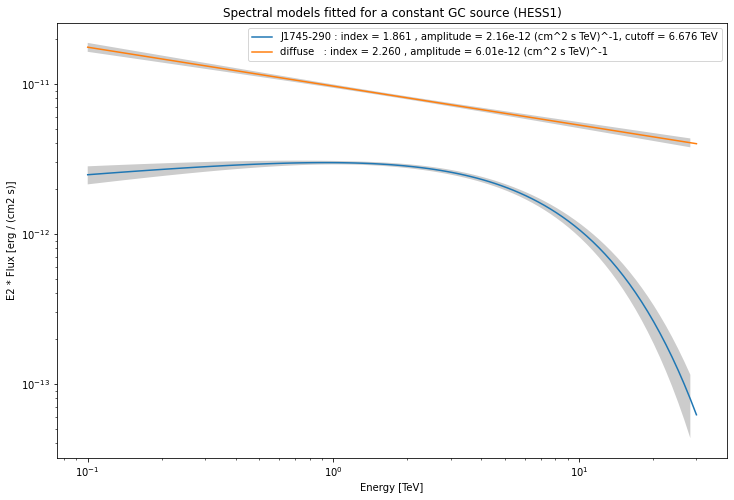

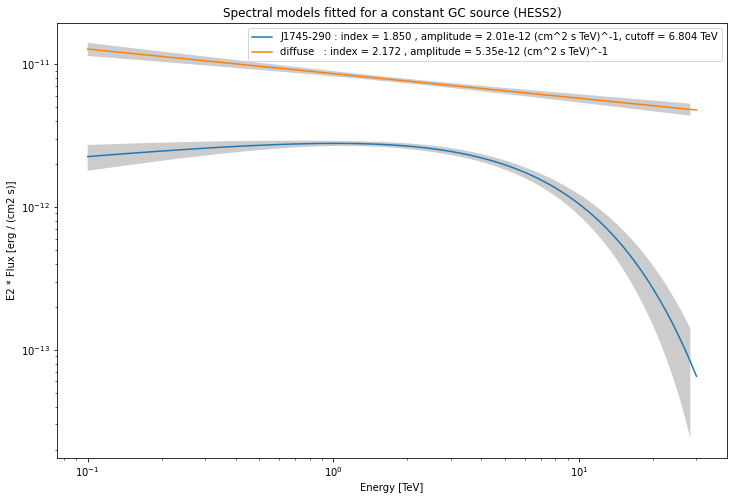

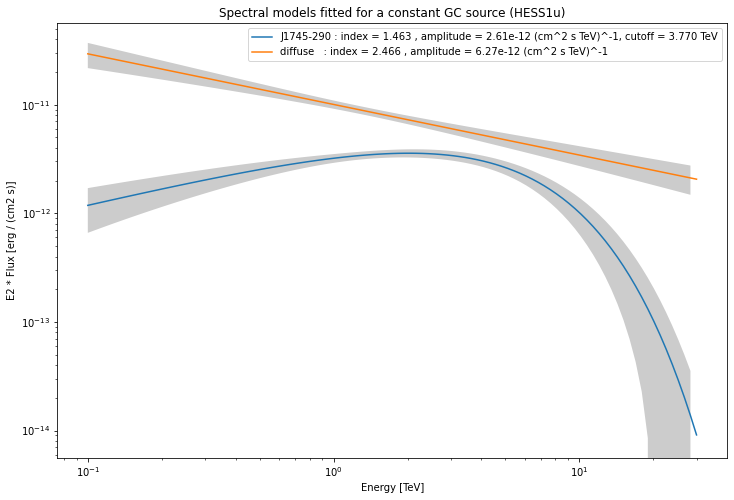

In [123]:
plot_spectrum(models_hess1,  pathtry,"hess1_model_1cutoff_3comp_fr.pdf", "HESS1")
plot_spectrum(models_hess2,  pathtry,"hess2_model_1cutoff_fr.pdf", "HESS2")
plot_spectrum(models_hess1u,  pathtry,"hess1u_model_1cutoff_fr.pdf", "HESS1u")

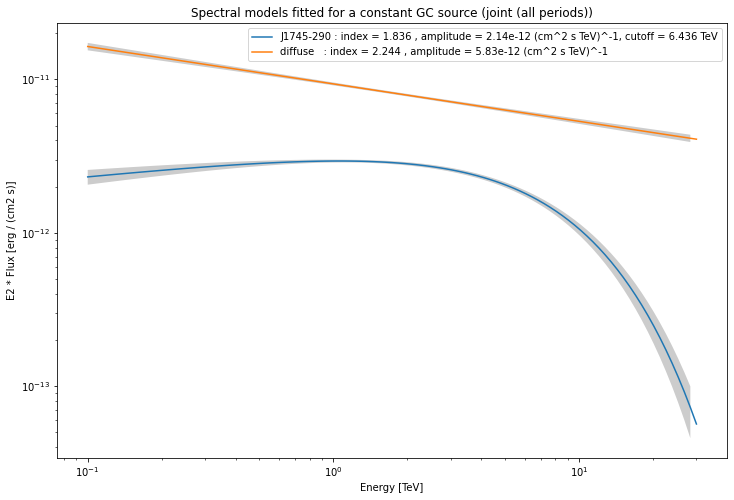

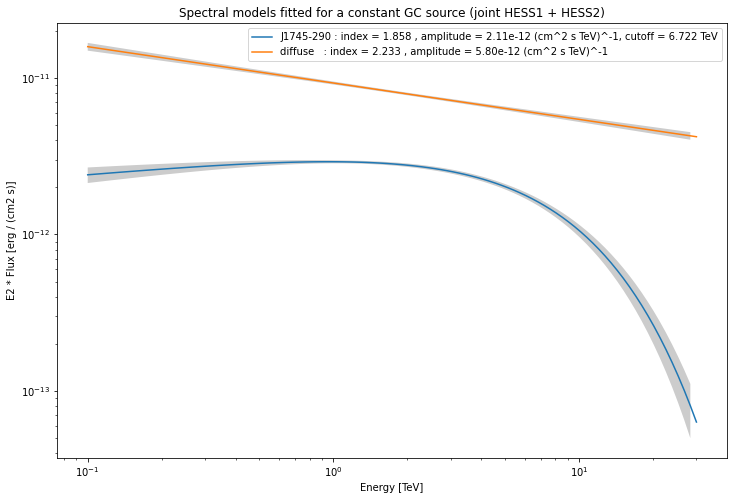

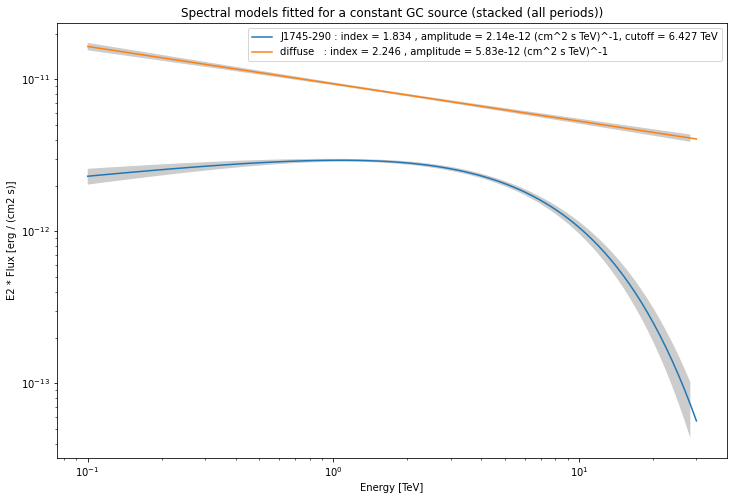

In [124]:
plot_spectrum(models_joint,  pathtry,"joint_model_1cutoff_fr.pdf", "joint (all periods)")
plot_spectrum(models_joint12,  pathtry,"joint12_model_1cutoff_fr.pdf", "joint HESS1 + HESS2")
plot_spectrum(models_stacked,  pathtry,"stacked_model_1cutoff_fr.pdf", "stacked (all periods)")

## Flux points

In [ ]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [ ]:
%%time

FPGC, DPDE = DoubleFluxPointsFitting(dataset_period, e_edges)

DoubleFluxPointsPlotting(FPGC, DPDE, "joint_2cutoff_fr", "joint fit (hap-fr)")

In [ ]:
DoubleFluxPointsFitting(dataset_stacked, e_edges, "stacked_1cutoff_fr", "stacked fit (hap-fr)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess1'], e_edges, "hess1_1cutoff_fr", "hess1 fit (hap-fr)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess2'], e_edges, "hess2_1cutoff_fr", "hess2 fit (hap-fr)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess1u'], e_edges, "hess1u_1cutoff_fr", "hess1u fit (hap-fr)")

## Maps

In [ ]:
plt.figure(figsize=(6,6))
dataset_period['hess1'].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"model_hess1_map.pdf")

In [ ]:
plt.figure(figsize=(6,6))
dataset_period['hess1'].counts.sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"counts_hess1_map.pdf")

## Residuals

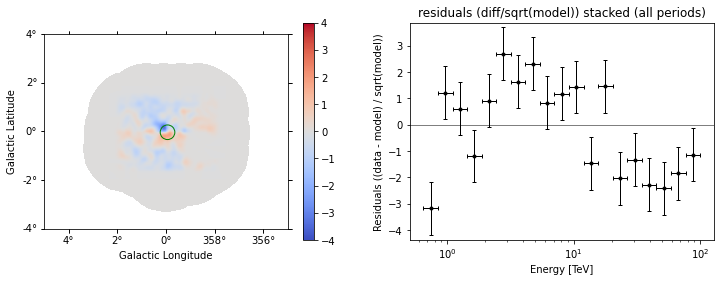

In [125]:
residuals(dataset_stacked,"stacked", "stacked (all periods)",vmax=4)

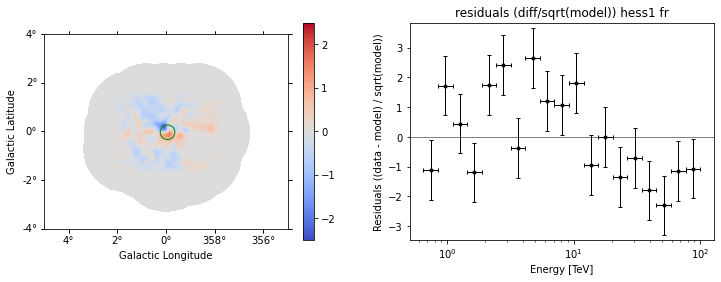

In [126]:
residuals(dataset_period['hess1'],"hess1", "hess1 fr", vmax=2.5)

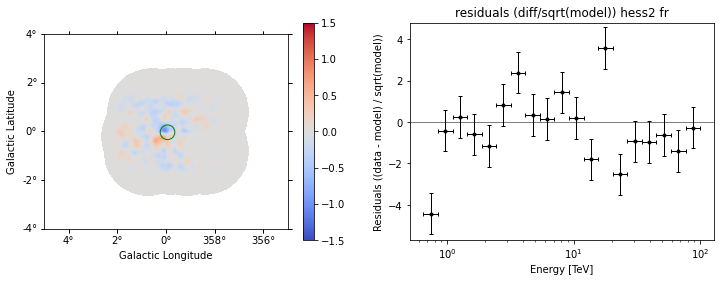

In [127]:
residuals(dataset_period['hess2'],"hess2", "hess2 fr",vmax=1.5)

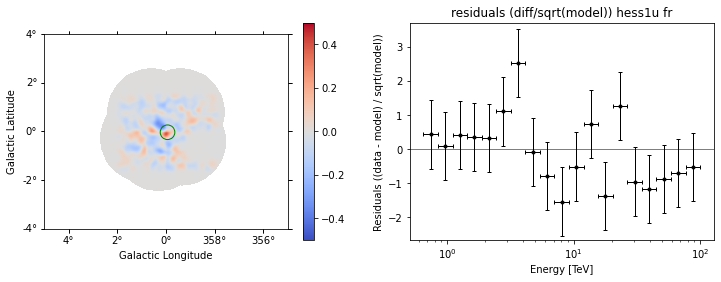

In [128]:
residuals(dataset_period['hess1u'],"hess1u", "hess1u fr",vmax=0.5)

## Significance map

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


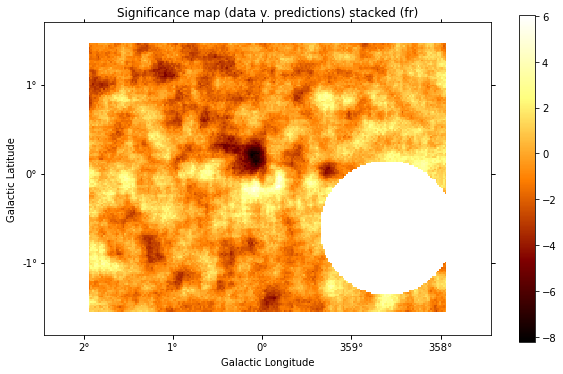

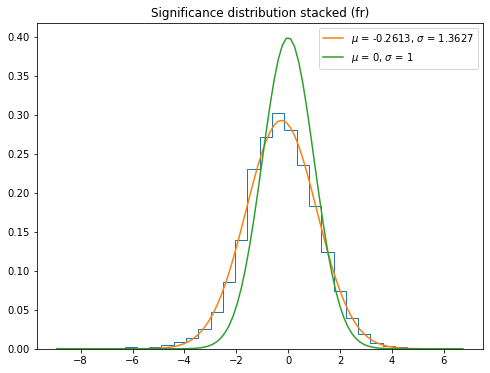

In [129]:
significance(dataset_stacked,"stacked", "stacked (fr)")

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


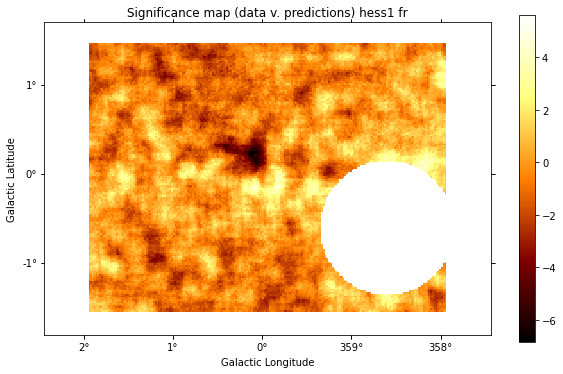

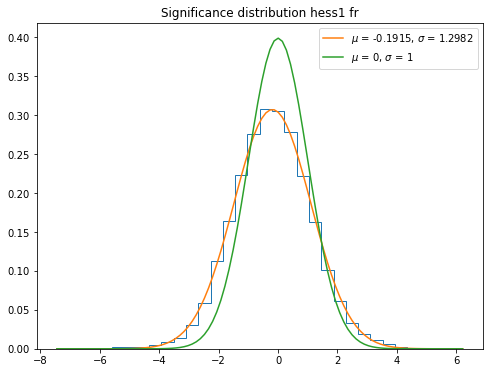

In [130]:
significance(dataset_period['hess1'],"hess1", "hess1 fr")

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


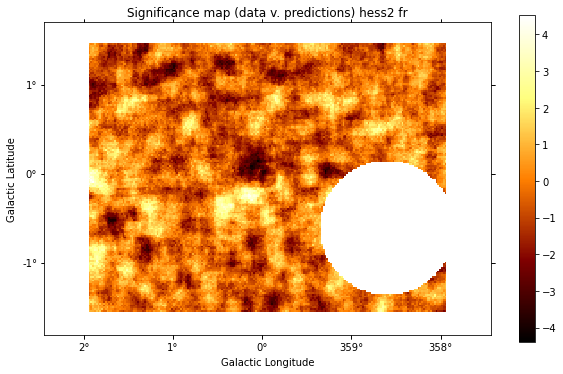

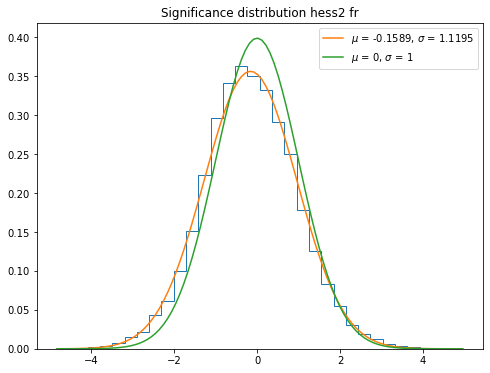

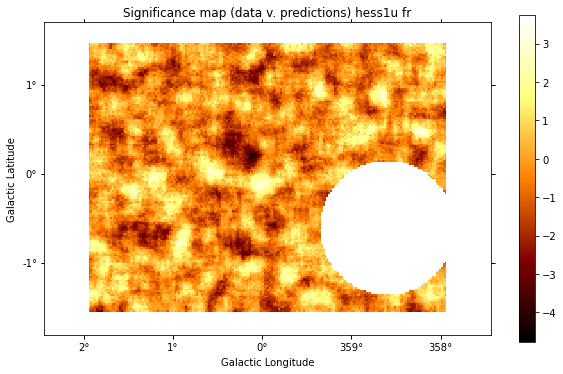

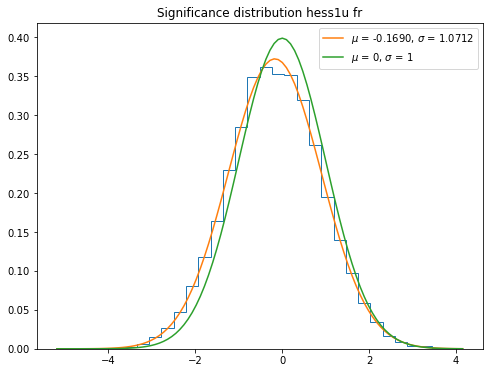

In [131]:
significance(dataset_period['hess2'],"hess2", "hess2 fr")
significance(dataset_period['hess1u'],"hess1u", "hess1u fr")

## Properly estimating the error on the parameter (using likelihood)

In [137]:
with open(pathtry/'errors.txt', "a") as out:
    out.write("")
    
dataset = dataset_period
models = dataset_period.models
table = result_joint.parameters.to_table()

In [138]:
%%time

param = models[0].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)
    
    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][2]
            )  + "\n"
        )

CPU times: user 2min 12s, sys: 41.2 ms, total: 2min 12s
Wall time: 2min 12s


In [139]:
%%time

param = models[2].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][13]
            )  + "\n"
        )

CPU times: user 1min 54s, sys: 16.6 ms, total: 1min 54s
Wall time: 1min 54s


In [140]:
%%time

param = models[0].spectral_model.parameters["lambda_"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][5]
            )  + "\n"
        )

CPU times: user 2min 7s, sys: 22.7 ms, total: 2min 7s
Wall time: 2min 7s


In [141]:
%%time

param = models[2].spectral_model.parameters["lambda_"]

if param.frozen == False:
    
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][16]
            )  + "\n"
        )

CPU times: user 37 µs, sys: 2 µs, total: 39 µs
Wall time: 41.2 µs


In [142]:
param = models[0].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "GC ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][3]
        )  + "\n"
    )


param = models[2].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][14]
        )  + "\n"
    )

# Confidence contours

What will be interesting is how spectral indices and energy cutoffs are correlated, but we might want to see how parameters from different models are correlated too

In [143]:
from gammapy.visualization.utils import plot_contour_line
from itertools import combinations

def make_contours_old(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "lambda_", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[par_1].tolist(),
                par_2: contour[par_2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma


def make_contours(fit, result, models, npoints, sigmas):
    
    indexGC = [models[0].spectral_model.parameters['index'], 'indexGC']
    indexDE = [models[2].spectral_model.parameters['index'], 'indexDE']
    lambdaGC = [models[0].spectral_model.parameters['lambda_'], 'lambdaGC']
    lambdaDE = [models[2].spectral_model.parameters['lambda_'], 'lambdaDE']
    params = [indexGC, indexDE, lambdaGC, lambdaDE] 
    # il ne les trouve pas
                
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(params, r=2):
            contour = fit.minos_contour(
                par_1[0],
                par_2[0],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1[1]}_{par_2[1]}"] = {
                par_1[1] : contour[par_1[0]].tolist(),
                par_2[1] : contour[par_2[0]].tolist(),
                }
        cts_sigma.append(contours)
    return cts_sigma

In [133]:
from iminuit import mncontour

#marche pas comme ça

def MinosContourCustom(fit , x, y, numpoints, sigma):
    
    with parameters.restore_values:
            result = mncontour(self.minuit, parameters, x, y, numpoints, sigma)

    x_name = x.name
    y_name = y.name
    x = result["x"] * x.scale
    y = result["y"] * y.scale

    return {
            x_name: x,
            y_name: y,
            "success": result["success"],
            f"{x_name}_info": result["x_info"],
            f"{y_name}_info": result["y_info"],
        }

ImportError: cannot import name 'mncontour' from 'iminuit' (/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/iminuit/__init__.py)

In [144]:
%%time

# different parameters with the same name

sigma = [1, 2]
cts_sigma = make_contours_old(fit_joint, result_joint, 10, sigma)

CPU times: user 1h 6min 1s, sys: 971 ms, total: 1h 6min 2s
Wall time: 1h 6min 6s


In [145]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-12}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$\Gamma$",
    "lambda": r"$\lambda$",
}


panels = [
    {
        "x": "index",
        "y": "phi",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "lambda",
        "y": "phi",
        "cx": (lambda ct: ct["contour_lambda__amplitude"]["lambda_"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_lambda__amplitude"]["amplitude"]
        ),
    },
    {
        "x": "index",
        "y": "lambda",
        "cx": (lambda ct: ct["contour_index_lambda_"]["index"]),
        "cy": (lambda ct: ct["contour_index_lambda_"]["lambda_"]),
    },
]

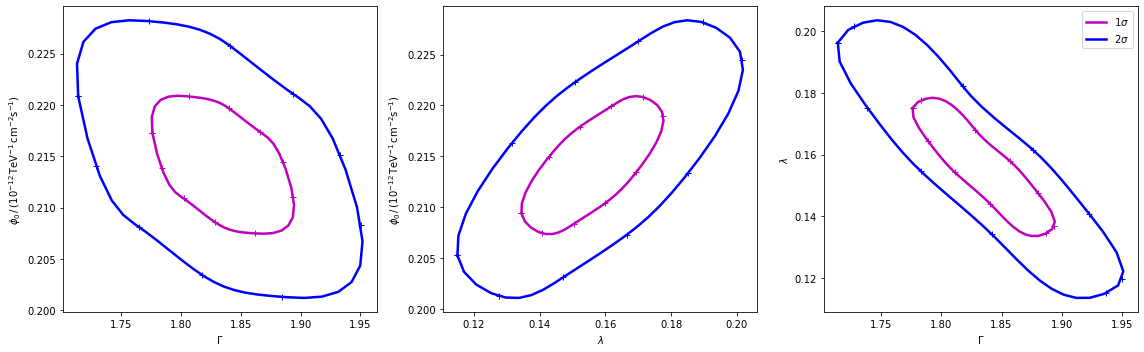

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()
plt.savefig(pathtry/"contours_GCspectrum_joint_fr.pdf")